# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import training
import PNN_Setting as ps
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [2]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'PMLC',
                        'data_processed', 'Dataset_Pendigits.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']
M, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, M, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## data preprocessing

In [3]:
# normalization
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [4]:
X[:10, :9]

tensor([[0.4700, 1.0000, 0.2700, 0.8100, 0.5700, 0.3700, 0.2600, 0.0000, 0.0000],
        [0.0000, 0.8900, 0.2700, 1.0000, 0.4200, 0.7500, 0.2900, 0.4500, 0.1500],
        [0.0000, 0.5700, 0.3100, 0.6800, 0.7200, 0.9000, 1.0000, 1.0000, 0.7600],
        [0.0000, 1.0000, 0.0700, 0.9200, 0.0500, 0.6800, 0.1900, 0.4500, 0.8600],
        [0.0000, 0.6700, 0.4900, 0.8300, 1.0000, 1.0000, 0.8100, 0.8000, 0.6000],
        [1.0000, 1.0000, 0.8800, 0.9900, 0.4900, 0.7400, 0.1700, 0.4700, 0.0000],
        [0.0000, 1.0000, 0.0300, 0.7200, 0.2600, 0.3500, 0.8500, 0.3500, 1.0000],
        [0.0000, 0.3900, 0.0200, 0.6200, 0.1100, 0.0500, 0.6300, 0.0000, 1.0000],
        [0.1300, 0.8900, 0.1200, 0.5000, 0.7200, 0.3800, 0.5600, 0.0000, 0.0400],
        [0.5700, 1.0000, 0.2200, 0.7200, 0.0000, 0.3100, 0.2500, 0.0000, 0.7500]])

In [5]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
test_rate = 0.2
M_train = int(M*train_rate)
M_test = int(M*test_rate)
train_data, rest_data = random_split(dataset, [M_train, M-M_train], generator=torch.Generator().manual_seed(19950102))
test_data, valid_data = random_split(rest_data, [M_test, M-M_train-M_test], generator=torch.Generator().manual_seed(19950102))
len(train_data), len(test_data), len(valid_data)

(6595, 2198, 2199)

In [6]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [7]:
N_Hidden = 16
m = 0.3
T = 0.1
K = 5  # number of time sampling
M = 40  # number of model sampling
K_test = 5
M_test = 10

# Normal NN
## Training

In [21]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


NN.apply(weights_init)

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
celoss = torch.nn.CrossEntropyLoss()
NN

Sequential(
  (0): Linear(in_features=16, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=10, bias=True)
  (3): Tanh()
)

In [22]:
train_loss_NN, test_loss_NN, parameter_NN = training.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.09782 | Loss: 2.433520555 |
| Epoch:   100 | Accuracy: 0.76661 | Loss: 1.177825809 |
| Epoch:   200 | Accuracy: 0.85851 | Loss: 1.015358686 |
| Epoch:   300 | Accuracy: 0.87352 | Loss: 0.953737378 |
| Epoch:   400 | Accuracy: 0.88171 | Loss: 0.922604620 |
| Epoch:   500 | Accuracy: 0.89263 | Loss: 0.905694723 |
| Epoch:   600 | Accuracy: 0.89718 | Loss: 0.893669248 |
| Epoch:   700 | Accuracy: 0.90628 | Loss: 0.884059668 |
| Epoch:   800 | Accuracy: 0.91174 | Loss: 0.876420736 |
| Epoch:   900 | Accuracy: 0.91583 | Loss: 0.871099234 |
| Epoch:  1000 | Accuracy: 0.91856 | Loss: 0.867481709 |
| Epoch:  1100 | Accuracy: 0.92175 | Loss: 0.864668489 |
| Epoch:  1200 | Accuracy: 0.92175 | Loss: 0.862232566 |
| Epoch:  1300 | Accuracy: 0.92584 | Loss: 0.860176206 |
| Epoch:  1400 | Accuracy: 0.93267 | Loss: 0.858444810 |
| Epoch:  1500 | Accuracy: 0.94177 | Loss: 0.856602967 |
| Epoch:  1600 | Accuracy: 0.97361 | Loss: 0.850466549 |
| Epoch:  1700 | Accuracy: 0.98

(7809, tensor(0.8263))

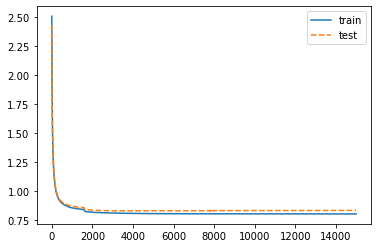

In [23]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## save model

In [24]:
with open('./pendigitresult/NN_16.p', 'wb') as f:
    pickle.dump(NN, f)

## load model

In [25]:
with open('./pendigitresult/NN_16.p', 'rb') as f:
    NN = pickle.load(f)

## evalutation

In [26]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.numpy()) / y_valid.shape[0]
print(acc_valid)

0.9854479308776717


# PNN
## Training

In [9]:
PNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
PNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

In [10]:
train_loss_PNN, test_loss_PNN, parameter_PNN = training.train_normal_pnn(
    PNN, train_loader, test_loader, m, T, optimizer_PNN, pnn.LossFunction, 15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.10328 | Loss: 1.395962777 |
| Epoch:   100 | Accuracy: 0.74886 | Loss: 0.602397839 |
| Epoch:   200 | Accuracy: 0.77070 | Loss: 0.416422436 |
| Epoch:   300 | Accuracy: 0.86442 | Loss: 0.261196786 |
| Epoch:   400 | Accuracy: 0.89354 | Loss: 0.192623468 |
| Epoch:   500 | Accuracy: 0.92630 | Loss: 0.161237013 |
| Epoch:   600 | Accuracy: 0.93949 | Loss: 0.143261454 |
| Epoch:   700 | Accuracy: 0.94359 | Loss: 0.131893629 |
| Epoch:   800 | Accuracy: 0.94859 | Loss: 0.123251981 |
| Epoch:   900 | Accuracy: 0.95132 | Loss: 0.116093401 |
| Epoch:  1000 | Accuracy: 0.95314 | Loss: 0.111037101 |
| Epoch:  1100 | Accuracy: 0.95314 | Loss: 0.107315043 |
| Epoch:  1200 | Accuracy: 0.95450 | Loss: 0.104318707 |
| Epoch:  1300 | Accuracy: 0.95359 | Loss: 0.101704803 |
| Epoch:  1400 | Accuracy: 0.95405 | Loss: 0.099584756 |
| Epoch:  1500 | Accuracy: 0.95678 | Loss: 0.097210446 |
| Epoch:  1600 | Accuracy: 0.95632 | Loss: 0.094913234 |
| Epoch:  1700 | Accuracy: 0.95

(6783, tensor(0.0670, dtype=torch.float64))

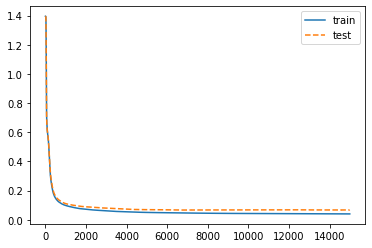

In [11]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## save PNN

In [12]:
with open('./pendigitresult/PNN_16.p', 'wb') as f:
    pickle.dump(PNN, f)

## load PNN

In [13]:
with open('./pendigitresult/PNN_16.p', 'rb') as f:
    PNN = pickle.load(f)

## Functions for setting times and models

In [ ]:
import PNN_Setting as ps
# ps.makemodel
# ps.settime
# ps.zerogradient

Usage of functions: 

`pnn.apply(lambda z: settime(z, time))`

`pnn.apply(makemodel)`

`pnn.apply(zerogradient)`

## evaluation

In [ ]:
import evaluation
importlib.reload(evaluation)
mean_acc_PNN, std_acc_PNN, mean_maa_PNN, std_maa_PNN = evaluation.FullEvaluation(PNN, valid_loader)

In [ ]:
plt.fill_between(np.linspace(0,1,50), mean_acc_PNN-std_acc_PNN, mean_acc_PNN+std_acc_PNN, alpha=0.3, color='blue');
plt.plot(np.linspace(0,1,50), mean_acc_PNN, label='PNN', color='blue');

plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

In [ ]:
plt.fill_between(np.linspace(0,1,50), mean_maa_PNN-std_maa_PNN, mean_maa_PNN+std_maa_PNN, alpha=0.3, color='blue');
plt.plot(np.linspace(0,1,50), mean_maa_PNN, label='PNN', color='blue');

plt.xlabel('normalized time');
plt.ylabel('measureing aware accuracy');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.legend();

# Aging Aware PNN
## Training

In [8]:
AAPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_class, age_generator))

optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
AAPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

### Functions for generating parallel AAPNNs

In [9]:
# ps.MakeParallelPNNs
# ps.MakeParallelModels

Usage:

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M, K)`, generating different models & different time stamps

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M)`, generating only different models

# Load temp parameter when corrupt

In [10]:
with open('./temp/AAPNN.p', 'rb') as f:
    AAPNN = pickle.load(f)

## Parallel Training

In [11]:
importlib.reload(training)
test_loss_AAPNN, parameter_AAPNN = training.ParallelTrainingAAPNN(AAPNN,
                                                                  train_loader, test_loader,
                                                                  optimizer_AAPNN,
                                                                  pnn.LossFunction, m, T,
                                                                  M, K, M_test, K_test, Epoch=700)

  0%|          | 0/700 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.94731 | Loss: 0.119449699 |
| Epoch:    10 | Accuracy: 0.94712 | Loss: 0.118456288 |
| Epoch:    20 | Accuracy: 0.94414 | Loss: 0.122467509 |
| Epoch:    30 | Accuracy: 0.94460 | Loss: 0.123668528 |
| Epoch:    40 | Accuracy: 0.94835 | Loss: 0.120239478 |
| Epoch:    50 | Accuracy: 0.94629 | Loss: 0.120257280 |
| Epoch:    60 | Accuracy: 0.94148 | Loss: 0.129778863 |
| Epoch:    70 | Accuracy: 0.94413 | Loss: 0.124345367 |
| Epoch:    80 | Accuracy: 0.94520 | Loss: 0.119336491 |
| Epoch:    90 | Accuracy: 0.94426 | Loss: 0.124273807 |
| Epoch:   100 | Accuracy: 0.94723 | Loss: 0.116826617 |
| Epoch:   110 | Accuracy: 0.94564 | Loss: 0.125007846 |
| Epoch:   120 | Accuracy: 0.94247 | Loss: 0.127981235 |
| Epoch:   130 | Accuracy: 0.94385 | Loss: 0.124011203 |
| Epoch:   140 | Accuracy: 0.94864 | Loss: 0.115404072 |
| Epoch:   150 | Accuracy: 0.94321 | Loss: 0.126193432 |
| Epoch:   160 | Accuracy: 0.94813 | Loss: 0.116995077 |
| Epoch:   170 | Accuracy: 0.94

KeyboardInterrupt: 

In [ ]:
plt.plot(test_loss_AAPNN);
AAPNN.load_state_dict(parameter_AAPNN);

## save AAPNN

In [12]:
with open('./pendigitresult/AAPNN_16.p', 'wb') as f:
    pickle.dump(AAPNN, f)

## read AAPNN

In [13]:
with open('./pendigitresult/AAPNN_16.p', 'rb') as f:
    AAPNN = pickle.load(f)

## Evaluation

In [ ]:
import evaluation
mean_acc_AAPNN, std_acc_AAPNN, mean_maa_AAPNN, std_maa_AAPNN = evaluation.FullEvaluation(AAPNN, valid_loader)

In [ ]:
plt.fill_between(np.linspace(0,1,50), mean_acc_AAPNN-std_acc_AAPNN, mean_acc_AAPNN+std_acc_AAPNN, alpha=0.3, color='red');
plt.plot(np.linspace(0,1,50), mean_acc_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

In [ ]:
plt.fill_between(np.linspace(0,1,50), mean_maa_AAPNN-std_maa_AAPNN, mean_maa_AAPNN+std_maa_AAPNN, alpha=0.3, color='red');
plt.plot(np.linspace(0,1,50), mean_maa_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('measureing aware accuracy');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.legend();